https://rmendels.github.io/Using_rerddap.nb.html

In [1]:
library('rerddap')
library('ggplot2')
library('mapdata')
library('dplyr')

Loading required package: maps

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



```R
?rerddap
```

In [2]:
whichSST <- ed_search(query='SST')
whichSST

# A tibble: 978 x 2
                                                                     title
                                                                     <chr>
 1 SST, Daily Optimum Interpolation (OI), AMSR+AVHRR, Version 2, 2002-2011
 2                SST from METOP AVHRR (GHRSST EUR-L3P-GLOB AVHRR METOP A)
 3                   Global SST Analysis (GHRSST EUR-L4HRfnd-GLOB-ODYSSEA)
 4           NAVOCEANO 10km Analyzed SST (GHRSST NAVO-L4HR1m-GLOB-K10 SST)
 5                        VIIRS SST NPP NAR-OSISAF-L3C-v1.0 (SST) [nj][ni]
 6  Multi-scale Ultra-high Resolution (MUR) SST analysis, NCAMERICA domain
 7                             fullAgg, JPL-L4UHblend-NCAMERICA-RTO SST Ad
 8                             fullAgg, JPL-L4UHblend-NCAMERICA-RTO SST Td
 9                             fullAgg, JPL-L4UHblend-NCAMERICA-RTO SST Tn
10                           SST from AMSRE onboard AQUA, 25 km resolution
# ... with 968 more rows, and 1 more variables: dataset_id <chr>

In [3]:
whichSST <- ed_search(query='SST MODIS')
whichSST

# A tibble: 193 x 2
                                                                              title
                                                                              <chr>
 1 SST, Aqua MODIS, NPP, 0.025 degrees, Pacific Ocean, Daytime, 2006-present (Month
 2 SST, Terra MODIS, NPP, Global, Nighttime (4 microns), 2000-2011, Science Quality
 3 SST, Terra MODIS, NPP, Global, Nighttime (4 microns), 2000-2011, Science Quality
 4 SST, Terra MODIS, NPP, Global, Nighttime (4 microns), 2000-2011, Science Quality
 5 SST, Terra MODIS, NPP, Global, Daytime (11 microns), 2000-2011, Science Quality 
 6 SST, Terra MODIS, NPP, Global, Daytime (11 microns), 2000-2011, Science Quality 
 7 SST, Terra MODIS, NPP, Global, Nighttime (11 microns), 2000-2011, Science Qualit
 8 SST, Terra MODIS, NPP, Global, Nighttime (11 microns), 2000-2011, Science Qualit
 9 SST, Aqua MODIS, NPP, 0.0125°, West US, Day time (11 microns), 2002-present (Mon
10 SST, Aqua MODIS, NPP, 0.025 degrees, Pacific Ocean, D

In [4]:
servers()

name,url
Marine Domain Awareness (MDA) - Italy,https://bluehub.jrc.ec.europa.eu/erddap/
Marine Institute - Ireland,http://erddap.marine.ie/erddap/
CoastWatch Caribbean/Gulf of Mexico Node,http://cwcgom.aoml.noaa.gov/erddap/
CoastWatch West Coast Node,https://coastwatch.pfeg.noaa.gov/erddap/
NOAA IOOS CeNCOOS (Central and Northern California Ocean Observing System),http://erddap.axiomalaska.com/erddap/
NOAA IOOS NERACOOS (Northeastern Regional Association of Coastal and Ocean Observing Systems),http://www.neracoos.org/erddap/
NOAA IOOS NGDAC (National Glider Data Assembly Center),http://data.ioos.us/gliders/erddap/
NOAA IOOS PacIOOS (Pacific Islands Ocean Observing System) at the University of Hawaii (UH),http://oos.soest.hawaii.edu/erddap/
NOAA IOOS SECOORA (Southeast Coastal Ocean Observing Regional Association),http://129.252.139.124/erddap/
NOAA NCEI (National Centers for Environmental Information) / NCDDC,http://ecowatch.ncddc.noaa.gov/erddap/


```R
browse('jplMURSST41')
```

In [5]:
sstInfo <- info('jplMURSST41')
sstInfo

<ERDDAP info> jplMURSST41 
 Dimensions (range):  
     time: (2002-06-01T09:00:00Z, 2017-10-01T09:00:00Z) 
     latitude: (-89.99, 89.99) 
     longitude: (-179.99, 180.0) 
 Variables:  
     analysed_sst: 
         Units: degree_C 
     analysis_error: 
         Units: degree_C 
     mask: 
     sea_ice_fraction: 
         Units: fraction 

In [6]:
murSST <- griddap(
    sstInfo,
    latitude=c(22., 51.),
    longitude=c(-140., -105),
    time=c('last', 'last'),
    fields='analysed_sst'
)

Warning message:
“Removed 4015788 rows containing missing values (geom_raster).”

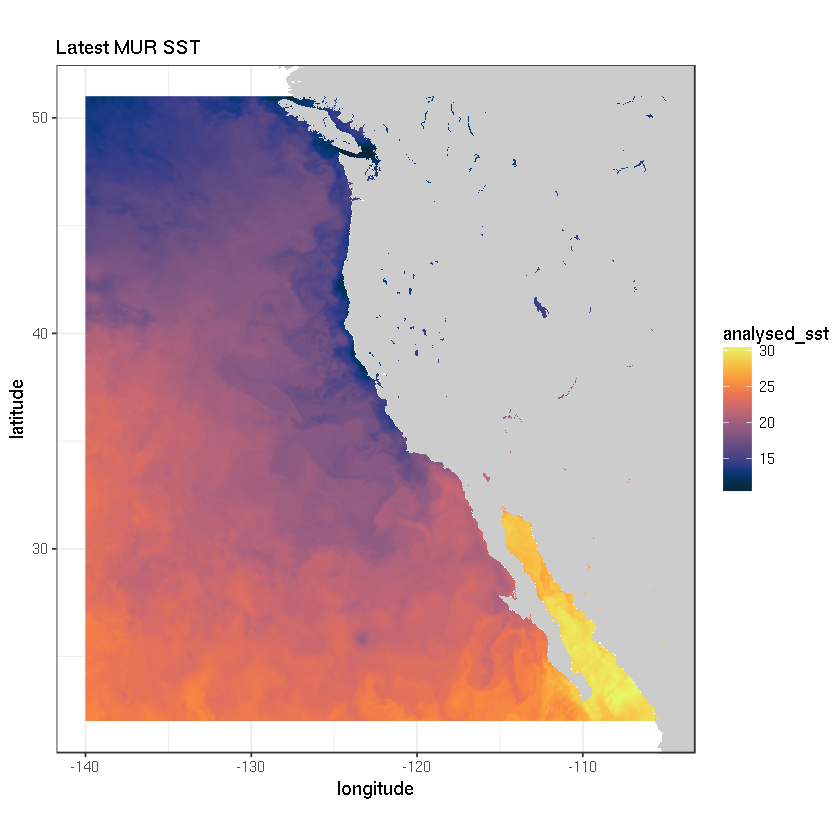

In [7]:
mycolor <- colors$temperature

w <- map_data(
    'worldHires',
    ylim=c(22., 51.),
    xlim=c(-140, -105)
)

ggplot(
    data=murSST$data,
    aes(x=lon, y=lat, fill=analysed_sst)) +
    geom_polygon(data=w, aes(x=long, y=lat, group=group), fill='grey80') +
    geom_raster(interpolate=FALSE) +
    scale_fill_gradientn(colours=mycolor, na.value=NA) +
    theme_bw() +
    ylab('latitude') +
    xlab('longitude') +
    coord_fixed(1.3, xlim=c(-140, -105),  ylim=c(22., 51.)) +
    ggtitle('Latest MUR SST')

In [8]:
hydroInfo <- info('siocalcofiHydroCasts')

fields = c('cst_cnt',  'date', 'year', 'month', 'julian_date', 'julian_day',
           'rpt_line', 'rpt_sta', 'cruz_num', 'intchl', 'intc14', 'time')

calcofi.df <- tabledap(
    hydroInfo,
    fields=fields,
    'time>=1984-01-01T00:00:00Z',
    'time<=2014-04-17T05:35:00Z'
)
str(calcofi.df)

Classes ‘tabledap’ and 'data.frame':	11072 obs. of  12 variables:
 $ cst_cnt    : int  22522 22523 22524 22525 22526 22527 22528 22529 22530 22531 ...
 $ date       : chr  "01/04/1984" "01/05/1984" "01/05/1984" "01/05/1984" ...
 $ year       : int  1984 1984 1984 1984 1984 1984 1984 1984 1984 1984 ...
 $ month      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ julian_date: int  30685 30686 30686 30686 30686 30686 30687 30687 30687 30687 ...
 $ julian_day : int  4 5 5 5 5 5 6 6 6 6 ...
 $ rpt_line   : num  93.3 90 90 90 90 90 90 90 90 90 ...
 $ rpt_sta    : num  29 35 30 28 32 37 53 53 53 53 ...
 $ cruz_num   : chr  "8401" "8401" "8401" "8401" ...
 $ intchl     : num  NaN 30.3 27.9 29.9 39.3 36.7 30.3 30.6 21.3 31.1 ...
 $ intc14     : chr  "NaN" "NaN" "NaN" "NaN" ...
 $ time       : chr  "1984-01-04T22:08:00Z" "1984-01-05T03:20:00Z" "1984-01-05T09:03:00Z" "1984-01-05T12:26:00Z" ...
 - attr(*, "datasetid")= chr "siocalcofiHydroCasts"
 - attr(*, "path")= chr "/tmp/RtmpFxcpvE/R/rerddap/a7a35af414deaa

In [9]:
calcofi.df$cruz_num <- as.numeric(calcofi.df$cruz_num)

calcofi.df$intc14 <- as.numeric(calcofi.df$intc14)
calcofi.df$time <- as.Date(
    calcofi.df$time,
    origin='1970-01-01',
    tz='GMT'
)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [10]:
by_cruznum <- group_by(calcofi.df, cruz_num)

tempData <- select(by_cruznum, year, month, cruz_num, intchl, intc14)

CruiseMeans <- summarize(
    by_cruznum,
    cruisechl=mean(intchl, na.rm=TRUE),
    cruisepp=mean(intc14, na.rm=TRUE),
    year=median(year, na.rm=TRUE),
    month=median(month, na.rm=TRUE)
)

tempTimes <- paste0(
    CruiseMeans$year,
    '-',
    CruiseMeans$month,
    '-1'
)

cruisetimes <- as.Date(
    tempTimes,
    origin='1970-01-01',
    tz='GMT'
)

CruiseMeans$cruisetimes <- cruisetimes

# Calculate monthly "climatologies."
byMonth <- group_by(CruiseMeans, month)
climate <- summarize(
    byMonth,
    ppClimate=mean(cruisepp, na.rm=TRUE),
    chlaClimate=mean(cruisechl, na.rm=TRUE)
)

# Calculate anomalies.
CruiseMeans$chlanom <- CruiseMeans$cruisechl - climate$chlaClimate[CruiseMeans$month]
CruiseMeans$ppanom <- CruiseMeans$cruisepp - climate$ppClimate[CruiseMeans$month]

# Calculate mean yearly anomaly.
byYear <- select(CruiseMeans, year)
tempData <- select(CruiseMeans, year, chlanom, ppanom )
byYear <- group_by(tempData, year)
yearlyAnom <- summarize(
    byYear,
    ppYrAnom=mean(ppanom, na.rm=TRUE),
    chlYrAnom=mean(chlanom, na.rm=TRUE)
)
yearlyAnom$year <- ISOdate(
    yearlyAnom$year, 01, 01, hour=0
)

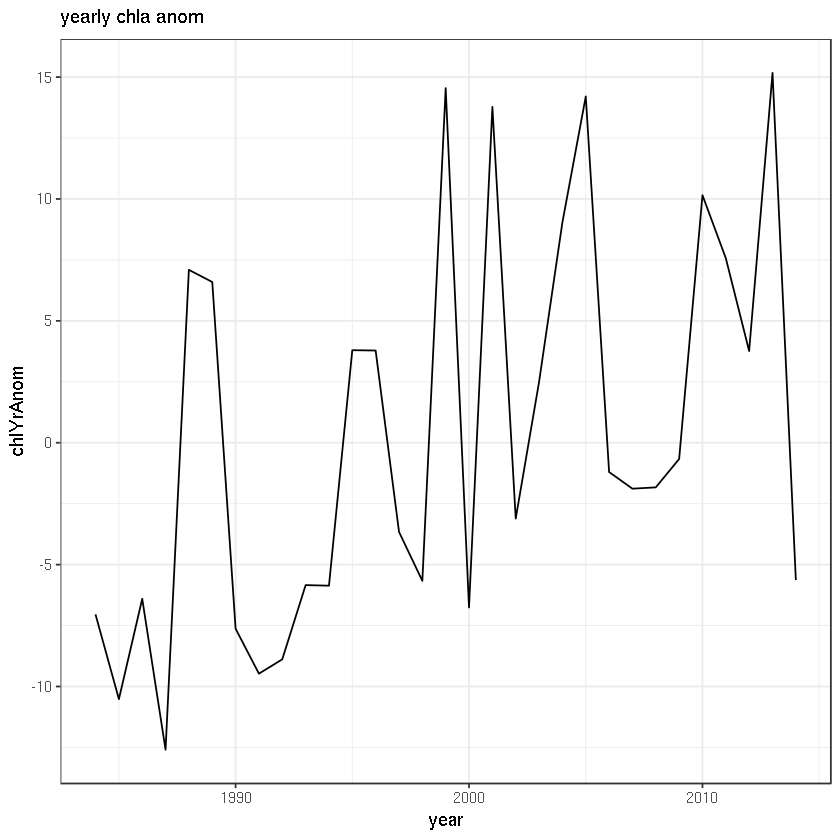

In [11]:
ggplot(yearlyAnom, aes(year, chlYrAnom)) + geom_line() + 
  theme_bw() + ggtitle('yearly chla anom')

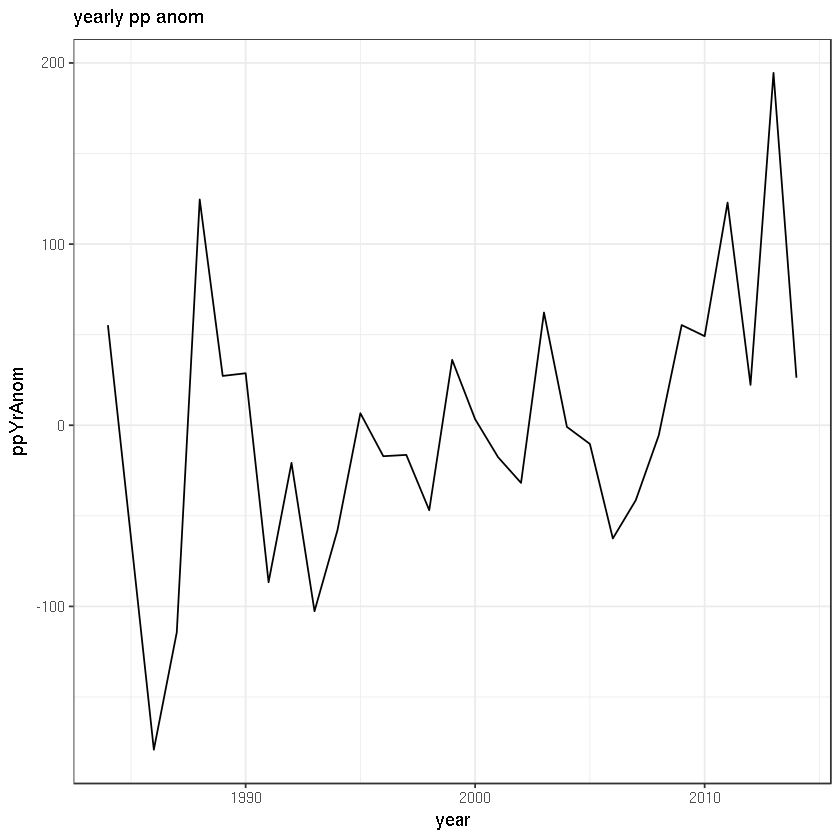

In [12]:
ggplot(yearlyAnom, aes(year, ppYrAnom)) + geom_line() + 
  theme_bw() + ggtitle('yearly pp anom')